The goal of this notebook is to qualitatively replicates Figure 4a [1], where Ye &  Pandarinath (2021) showed that (Neural Data Transformers) NDT can learn a spike-to-rate-mapping in a synthetic dataset generated from the Lorenz equation. 

Summary: 
- A single-layer transformer can capture the spike-to-rate mapping in the Lorenz dataset fairly well but its performance is worse than the 6-layer transformer reported in Figure 4a [1]. 


Implementation detail: 
- One important difference is that the orignal paper [1] used a 6-layer transformer whereas I used a 1-layer transformer. Based on prior empirical results from [1], some performance decline is expected. 
- Since the NDT is a standard transformer architecture, I picked Keras since 1) the code can be more compact when implementing standard architectures and 2) this notebook can be executed with minimal dependencies. 
- Due to time constraints, I didn't not perform hyperparameter search like [1]. Instead, I mostly adpoted the hyperparameters from [1], such as the dropout rate, learning rate, number of attention heads, etc. On the other hand, for simplicity, code readability and speed (in case you wan to to run this notebook, it takes less than 2 mins), I did not adopt some of the training parameters, such as the number of training epochs, batch size, the way I normalize the data. I also simplified transformer masking data binning, etc. Despite these differences, the results does seem to replicate qualitatively. Overall, this replication is not meant to be an exact copy of NDT [1]. 

My implementation is mainly based on ... 
- [1] Ye, J., & Pandarinath, C. (2021). Representation learning for neural population activity with Neural Data Transformers. In arXiv [q-bio.NC]. arXiv. http://arxiv.org/abs/2108.01210
    - Code: https://github.com/snel-repo/neural-data-transformers  
    - For example, I modified/used the the h5 data loading function to load the Lorenz data (see utils.py).
- [2] A keras tutorial of an End-to-end Masked Language Modeling with BERT: https://keras.io/examples/nlp/masked_language_modeling/

by Qihong Lu (2021)

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import get_data_from_h5, DATASET_MODES, Config
from pprint import pprint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from dataclasses import dataclass

# set random seed
seed = 0 
tf.keras.utils.set_random_seed(seed)
config = Config()

In [2]:
'''load data'''
fpath = "data/lfads_lorenz.h5"
spikes_train, rates_train, heldout_spikes_train, forward_spikes_train = get_data_from_h5(
    DATASET_MODES.train, fpath)
spikes_val, rates_val, heldout_spikes_val, forward_spikes_val = get_data_from_h5(
    DATASET_MODES.val, fpath)

# normalize the data 
rates_train_n = (rates_train - rates_train.min()) / (rates_train.max() - rates_train.min())
rates_val_n = (rates_val - rates_val.min()) / (rates_val.max() - rates_val.min())

num_trials_train, trial_length, num_neurons = np.shape(spikes_train)
num_trials_val, trial_length, num_neurons = np.shape(spikes_val)

# simplification, to be fixed later
config.MAX_LEN, config.EMBED_DIM = trial_length, num_neurons

print(num_trials_train, trial_length, num_neurons)
print(num_trials_val, trial_length, num_neurons)

1248 50 29
312 50 29


In [3]:
'''build a transformer'''

def bert_module(query, key, value):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_multiheadattention",
    )(query, key, value)
    attention_output = layers.Dropout(config.DROPOUT_RATE, name="encoder_att_dropout")(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=config.EPSILON, name="encoder_att_layernormalization"
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_ffn",
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(config.DROPOUT_RATE, name="encoder_ffn_dropout")(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=config.EPSILON, name="encoder_ffn_layernormalization"
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        features, labels = inputs
        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=None)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=None)
        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    # use the input spikes, remove the embedding, which is optional [1]
    inputs = layers.Input((config.MAX_LEN, config.EMBED_DIM), dtype=tf.float32)
    i2h = layers.Dense(config.EMBED_DIM, activation='relu', input_shape=(config.MAX_LEN,))(inputs)
    # positional embedding
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = inputs + position_embeddings    
    encoder_output = bert_module(embeddings, embeddings, embeddings)
    mlm_output = layers.Dense(config.EMBED_DIM, name="mlm_reg", activation="sigmoid")(encoder_output)
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


In [4]:
'''init the model'''

# define the loss function 
loss_fn = tf.keras.losses.Poisson(reduction=tf.keras.losses.Reduction.NONE)
loss_tracker = tf.keras.metrics.Mean(name="loss")
# init the transformer 
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 29)]     0           []                               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 50, 29)      0           ['input_1[0][0]']                
 da)                                                                                              
                                                                                                  
 encoder_multiheadattention (Mu  (None, 50, 29)      3361        ['tf.__operators__.add[0][0]',   
 ltiHeadAttention)                                                'tf.__operators__.add[0][0]',   
                                                                  'tf.__operators_

In [5]:
""" Train and Save """
n_epochs = 50
X_train, Y_train = tf.convert_to_tensor(spikes_train), tf.convert_to_tensor(rates_train_n)
for i in range(n_epochs):
    bert_masked_model.fit(X_train, Y_train)

39/39 [==============================] - 0s 7ms/step - loss: 0.8347


In [6]:
'''plotting params'''
cp = sns.color_palette()
sns.set(style='white', palette='colorblind', context='poster')
alpha = .5

fig_path = 'figs/'

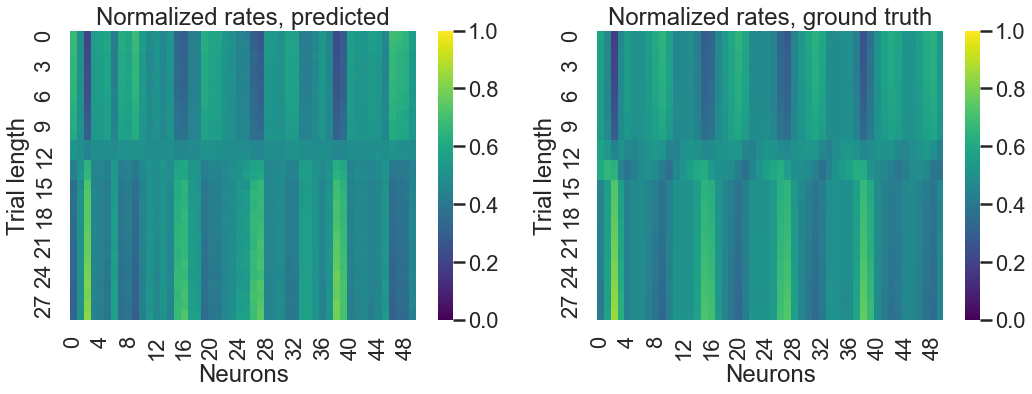

In [7]:
'''test the model on the validation set and visualize the target vs. predicted'''

x_val, y_val = tf.convert_to_tensor(spikes_val), rates_val_n
yhat = bert_masked_model.predict(x_val)

# pick the ith trial
i = 0 

vmax = np.max([np.max(yhat), np.max(y_val)])
vmin = np.min([np.min(yhat), np.min(y_val)])
f, axes = plt.subplots(1,2,  figsize=(15,6))
sns.heatmap(yhat[i].T,ax=axes[0], cmap='viridis',vmax=vmax,vmin=vmin)
sns.heatmap(y_val[i].T,ax=axes[1], cmap='viridis',vmax=vmax,vmin=vmin)
axes[0].set_title('Normalized rates, predicted')
axes[0].set_ylabel('Trial length')
axes[0].set_xlabel('Neurons')
axes[1].set_title('Normalized rates, ground truth')
axes[1].set_ylabel('Trial length')
axes[1].set_xlabel('Neurons')
f.tight_layout()

fig_name = 'rates_heatmap'
f.savefig(fig_path + fig_name)

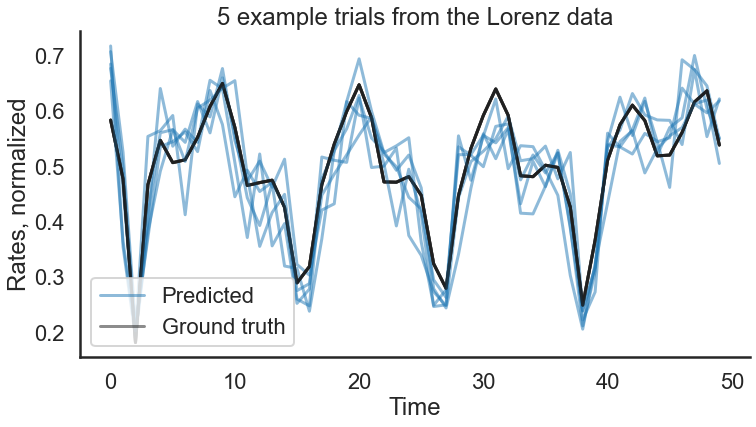

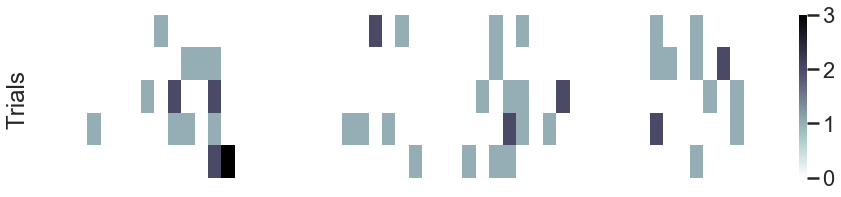

In [8]:
'''visualize some example trials (figure 4a)'''
# pick the jth neuron and the number of trials to plot (including too many trials makes the results hard to see)
j = 0 
n_trial_to_plot = 5

f, ax = plt.subplots(1,1,  figsize=(12,6))
for i in range(n_trial_to_plot):
    if i == 0: 
        label_yhat, label_y = 'Predicted', 'Ground truth'
    else:
        label_yhat, label_y = None, None        
    
    ax.plot(yhat[i][:,j], label = label_yhat, color = cp[0], alpha = alpha)
    ax.plot(y_val[i][:,j], label = label_y, color = 'k', alpha = alpha)
    ax.set_xlabel('Time')
    ax.set_ylabel('Rates, normalized')
    ax.set_title(f'{n_trial_to_plot} example trials from the Lorenz data')    
    ax.legend()
    sns.despine()

fig_name = 'rates_fig4a1'
f.savefig(fig_path + fig_name)    
    
f, ax = plt.subplots(1,1,  figsize=(15,3))
sns.heatmap(spikes_val[i][:,:n_trial_to_plot].T, cmap='bone_r')
ax.set_ylabel('Trials \n\n')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig_name = 'rates_fig4a2'
f.savefig(fig_path + fig_name)    